In [1]:
'''Import packages for loading data, analysing, and plotting'''
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import regionmask
import pandas as pd
import cartopy
import cartopy.crs as ccrs

from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.colors as colors

import numpy.ma as ma

from matplotlib.ticker import AutoMinorLocator

from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

# AR6 Regions

In [2]:
regionmask.defined_regions.ar6.all

<regionmask.Regions>
Name:     AR6 reference regions
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
 0 GIC      Greenland/Iceland
 1 NWN      N.W.North-America
 2 NEN      N.E.North-America
 3 WNA        W.North-America
 4 CNA        C.North-America
..  ..                    ...
53 ARS            Arabian-Sea
54 BOB          Bay-of-Bengal
55 EIO Equatorial.Indic-Ocean
56 SIO          S.Indic-Ocean
57 SOO         Southern-Ocean

[58 regions]

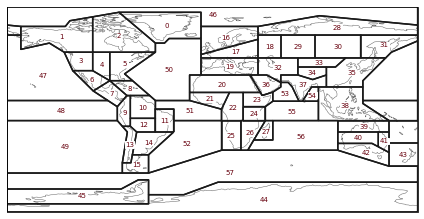

In [3]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))
regionmask.defined_regions.ar6.all.plot(text_kws=text_kws);
plt.tight_layout()

In [4]:
!pwd

/home/ucfaccb/Documents/local_repos/PMIP_for_AR6_Interactive_Atlas/scripts


In [5]:
load_data=xr.open_dataset('../netcdfs/ensemble_differences/pr_monClim_PMIP4_lig127k-piControl_percentage.nc')
pr=load_data.pr
lat=load_data.lat
pr

<xarray.DataArray 'pr' (model: 16, month: 12, lat: 180, lon: 360)>
[12441600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: model, month

In [6]:
load_data=xr.open_dataset('../netcdfs/ensemble_differences/tas_monClim_PMIP4_lig127k-piControl.nc')
tas=load_data.tas
lat=load_data.lat
tas

<xarray.DataArray 'tas' (model: 16, month: 12, lat: 180, lon: 360)>
[12441600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: model, month

In [7]:
# Create latitudinal weights
weight=pr[0,0,:,:] #using tas to copy over metadata  #select the 1st timestep
weight.values=np.ones((180,360)) 
for i in range(0,180):           
    w=lat[i].values*np.pi/180
    wc=np.cos(w)
    weight.values[i,:]=np.repeat(wc,360)


In [8]:
# create a mask defining all the AR6 region on correct grid
mask = regionmask.defined_regions.ar6.all.mask(load_data)

In [9]:
# Apply masks to DataArray's
pr_masked = pr.where(mask == 20)
tas_masked = tas.where(mask == 30)

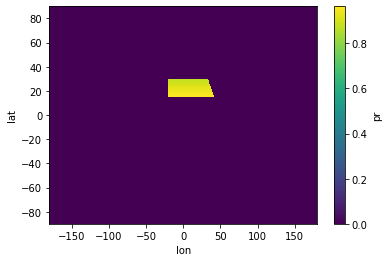

In [10]:
# Make bespoke masks for area averaging
weight_SIB=weight.where(mask == 30)
weight_SIB=xr.where(xr.ufuncs.isnan(weight_SIB),0,weight_SIB)
weight_SAH=weight.where(mask == 20)
weight_SAH=xr.where(xr.ufuncs.isnan(weight_SAH),0,weight_SAH)
weight_SAH.plot()

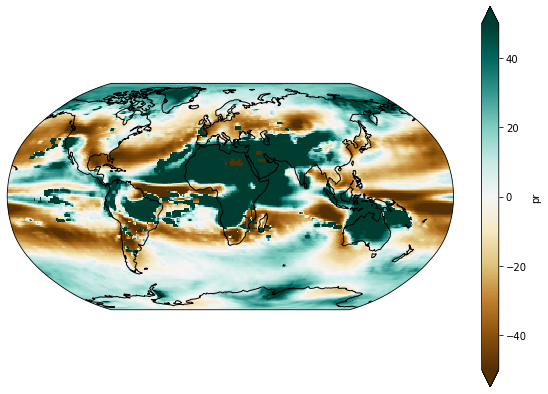

In [11]:
# Plot the ensemble average precipitation changes...
cmap=plt.get_cmap('BrBG')
plt.figure(figsize=(10,7))
proj=ccrs.Robinson(central_longitude=20)

ax = plt.subplot(111, projection=proj)

# select a specific time (i.e. 2000-1-16)
all_aug=pr[:,7,:,:].mean(axis=0,skipna=True)
all_aug

# do the plot
all_aug.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),vmax=50,vmin=-50, cmap=cmap)
ax.coastlines()

In [12]:
# Compute the area averages
SAH_avgs=np.ones((16,12))*-999.
SIB_avgs=np.ones((16,12))*-999.

for mod in range (0,16):   #apply the weight values calculated from the 1st timestep to all 3012 timesteps
    for mon in range (0,12):   #apply the weight values calculated from the 1st timestep to all 3012 timesteps
        SAH_avgs[mod,mon]=np.average(pr[mod,mon,:,:],weights=weight_SAH)
        SIB_avgs[mod,mon]=np.average(tas[mod,mon,:,:],weights=weight_SIB)

#Plot CESM2 values        
print(SAH_avgs[2,:])
SIB_avgs[2,:]

[  67.23393034   24.33502096   13.97567841   -6.90730002   18.09858037
   42.60607293 4808.32688629 6573.39934545 1588.09446078  314.3454086
   94.34499555   40.59573238]


array([-1.72452968, -3.17153491, -4.12944743, -2.68402959,  0.18245226,
        5.41783667,  7.84247201,  6.40190568,  3.87327514,  1.37639265,
        0.74556956, -0.31443374])

In [15]:
# Try the %-age precip change in area-averaged quantities instead...
lig=xr.open_dataset('../netcdfs/ensemble_combined/pr_monClim_PMIP4_lig127k.nc')
pi=xr.open_dataset('../netcdfs/ensemble_combined/pr_monClim_PMIP4_piControl_for_lig127k.nc')

SAH_avgs=np.ones((16,12))*-999.
for mod in range (0,16):   #apply the weight values calculated from the 1st timestep to all 3012 timesteps
    for mon in range (0,12):   #apply the weight values calculated from the 1st timestep to all 3012 timesteps
        pi_SAH=np.average(pi.pr[mod,mon,:,:],weights=weight_SAH)
        lig_SAH=np.average(lig.pr[mod,mon,:,:],weights=weight_SAH)
        SAH_avgs[mod,mon]=100*(lig_SAH-pi_SAH)/pi_SAH

#Plot CESM2 values        
print(SAH_avgs[2,:])


[-2.62561892e+00 -1.30735957e-01 -5.79118980e+00 -1.34996699e+01
  9.91787456e+00  5.19938109e+01  3.24682114e+02  2.30611847e+02
  3.67685054e+02  2.00445216e+02 -1.94787240e+01 -7.98162246e+00]


__Those are exactly the numbers that I read off the Interactive Atlas for the rainfall changes. Must be done correctly now. Wahey!__